In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Build vocabulary and mappings
chars = sorted(list(set("".join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0

i_to_s = {i: s for s, i in s_to_i.items()}

vocab_size = len(s_to_i)

In [4]:
CONTEXT_LENGTH = 3  # Block size: number of previous characters to consider when predicting the next character


def build_dataset(words, label):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * CONTEXT_LENGTH

        for char in word + ".":
            ix = s_to_i[char]
            X.append(context)
            Y.append(ix)

            # print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
            context = context[1:] + [ix]

        # print("=" * 10)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(label, X.shape, Y.shape)
    return X, Y

In [5]:
random.seed(42)

# Shuffle the words in the dataset
random.shuffle(words)

# Split the dataset into train, validation and test sets
train_index = int(0.8 * len(words))
val_index = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:train_index], "train")
X_val, Y_val = build_dataset(words[train_index:val_index], "validation")
X_test, Y_test = build_dataset(words[val_index:], "test")

train torch.Size([182625, 3]) torch.Size([182625])
validation torch.Size([22655, 3]) torch.Size([22655])
test torch.Size([22866, 3]) torch.Size([22866])


## MLP model - deeper look

### Base model

In [6]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)
W1 = torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g)

b1 = torch.randn(size=(num_neurons,), generator=g)
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g)
b2 = torch.randn(size=(vocab_size,), generator=g)

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [40]:
epochs = 200000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1  # hidden layer, pre-activation
    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 100000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")
        
    losses.append(loss.log10().item())

0/200000 | Loss: 30.4976


KeyboardInterrupt: 

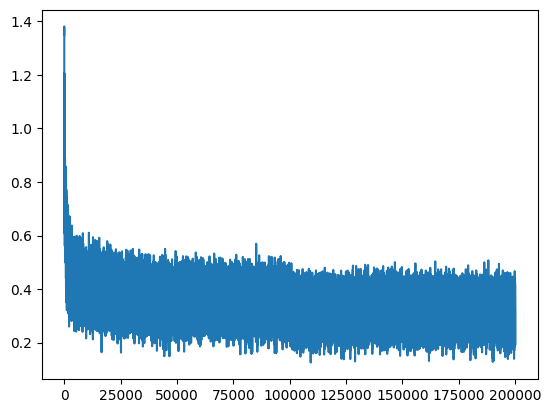

In [8]:
plt.plot(losses)

In [7]:
# Caculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 26.0047
validation loss: 26.0105


In [11]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
starting_string = "..."

for _ in range(20):
    out = []
    context = [s_to_i[s] for s in starting_string]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh((emb.view(1, -1) @ W1) + b1)
        logits = (h @ W2) + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(
            probs, num_samples=1, replacement=True, generator=g
        ).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print((starting_string + "".join([i_to_s[i] for i in out])).replace(".", ""))

mona
mayah
see
melyn
alarethan
emdraege
deredieliigh
parelle
elieananaraelynn
honea
noshabergahimies
kin
renlynn
nochomi
brence
ruylynn
els
kayshanna
daihan
salynn


### Initialization parameters

By assigning random values at initialization, we introduce extremely high loss in the model that it must overcome before it can learn anything new. To overcome this, for this particular problem, we can initialize the weights using the theory that with no additional knowledge, all characters are equally likely to be predicted. This means that:

$$
\begin{align}
p_c = \frac{1}{N_c} = \frac{1}{27}
\end{align}
$$

In [6]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)

W1 = torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g)
b1 = torch.randn(size=(num_neurons,), generator=g)

# Multiply W2 by a small number to reduce the magnitude of the output logits
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g) * 0.01
# Multiply b2 by 0 to remove the bias from the output logits initially
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [7]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1  # hidden layer, pre-activation
    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.3159
10000/100000 | Loss: 2.4973
20000/100000 | Loss: 2.5749
30000/100000 | Loss: 2.2919
40000/100000 | Loss: 2.1842
50000/100000 | Loss: 1.7794
60000/100000 | Loss: 2.3380
70000/100000 | Loss: 1.7547
80000/100000 | Loss: 2.1785
90000/100000 | Loss: 2.1536


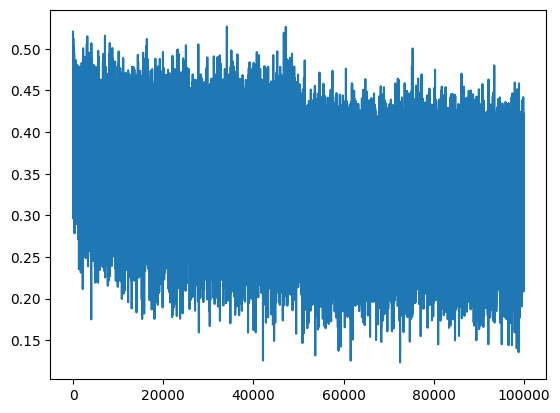

In [8]:
plt.plot(losses)

In [9]:
# Caculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.1000
validation loss: 2.1496


### Saturated `tanh`

In [31]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)

W1 = torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g)
b1 = torch.randn(size=(num_neurons,), generator=g)

# Multiply W2 by a small number to reduce the magnitude of the output logits
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g) * 0.01
# Multiply b2 by 0 to remove the bias from the output logits initially
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [32]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1  # hidden layer, pre-activation
    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

    break

0/100000 | Loss: 3.3358


#### Meaning of saturtation
After the first epoch, tanh is quite active, as indicated by the high frequency of values close to -1 and 1. 

This happens because the pre-activated matrix that feeds into the tanh function is quite broad, leading to lots of numbers taking on the extreme values as `tanh` caps them at -1 and 1


#### Why is this bad?
Because the derivate of `tanh` is given by $1-\tanh^2(x)$, at the extremes, the derivative is close to 0. This means that the corresponding neurons will learn that the gradient is close to 0 and will not learn anything. This is called **saturating** the neurons.

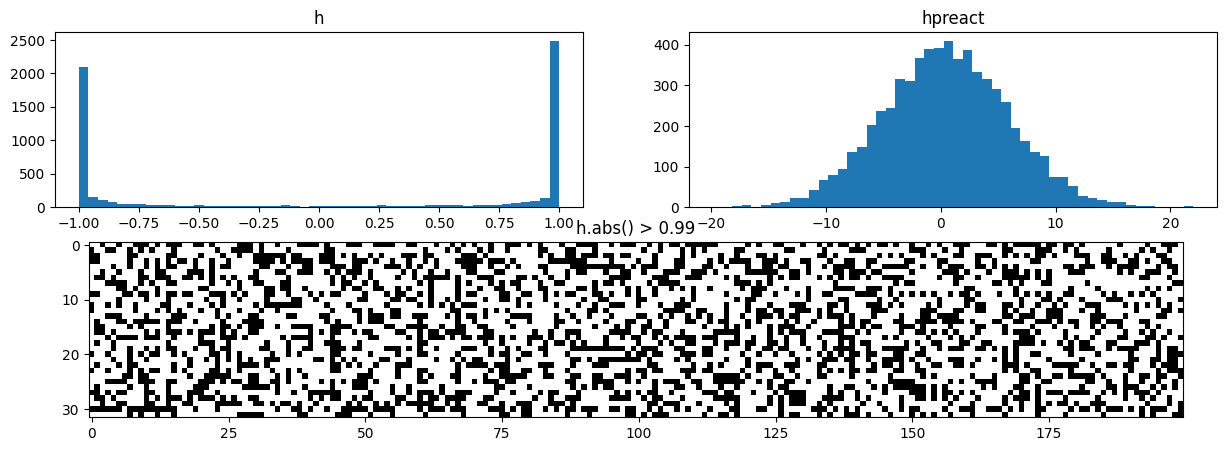

In [55]:
fig = plt.figure(figsize=(15, 5))

ax1_0 = fig.add_subplot(221)
ax1_0.hist(h.view(-1).tolist(), bins=50)
ax1_0.set_title("h")

ax1_1 = fig.add_subplot(222)
ax1_1.hist(hpreact.view(-1).tolist(), bins=50)
ax1_1.set_title("hpreact")

ax2 = fig.add_subplot(212)
ax2.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
ax2.set_title("h.abs() > 0.99")

plt.show()

#### How to fix?

Similar to how we fixed the initialization problem, we can initialize the weights such that the pre-activated matrix is not too broad


In [59]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)

# Multiply W1 by a small number to reduce the magnitude of the hidden layer pre-activations
W1 = torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g) * 0.2

# Multiply b1 by a small number to reduce the magnitude of the hidden layer pre-activations
b1 = torch.randn(size=(num_neurons,), generator=g) * 0.01

# Multiply W2 by a small number to reduce the magnitude of the output logits
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g) * 0.01

# Multiply b2 by 0 to remove the bias from the output logits initially
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [62]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1  # hidden layer, pre-activation
    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.2308
10000/100000 | Loss: 2.1702
20000/100000 | Loss: 2.3025
30000/100000 | Loss: 2.1418
40000/100000 | Loss: 2.1069
50000/100000 | Loss: 2.3626
60000/100000 | Loss: 2.3268
70000/100000 | Loss: 2.1364
80000/100000 | Loss: 1.8889
90000/100000 | Loss: 1.9787


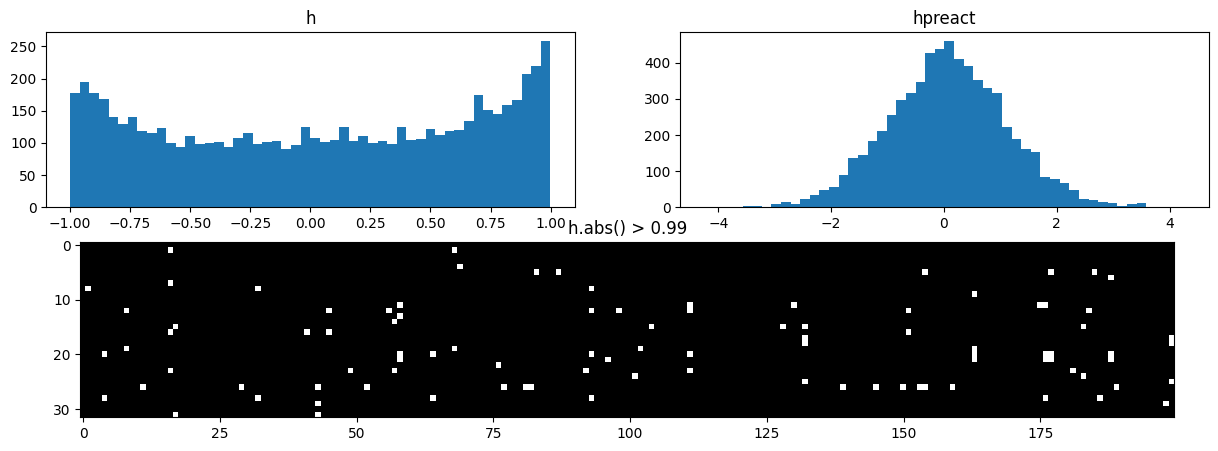

In [61]:
# !-- DON'T RUN THIS CELL AFTER TRAINING THE NETWORK --!
# Visualizing the activation after the first epoch

# fig = plt.figure(figsize=(15, 5))

# ax1_0 = fig.add_subplot(221)
# ax1_0.hist(h.view(-1).tolist(), bins=50)
# ax1_0.set_title("h")

# ax1_1 = fig.add_subplot(222)
# ax1_1.hist(hpreact.view(-1).tolist(), bins=50)
# ax1_1.set_title("hpreact")

# ax2 = fig.add_subplot(212)
# ax2.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
# ax2.set_title("h.abs() > 0.99")

# plt.show()

In [63]:
# Caculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0621
validation loss: 2.1118


### Kaiming init

Kaiming init is a method of initializing the weights such that the pre-activated matrix is not too broad. 

The default way of is to use the square root of the number of inputs to the layer, i.e., $\sqrt{(N_{I})}$.

The Kaiming-normal initialization for `tanh` is given by:
$$
\begin{align}
\text{std} &= \frac{5/3}{\sqrt{(N_{L})}} \\
\end{align}
$$

where $N_{L}$ is the number of input neurons in the layer. 

Read more [here.](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

X.mean()=tensor(-0.0069), X.std()=tensor(0.9999)
preacts.mean()=tensor(-0.0034), preacts.std()=tensor(1.0136)


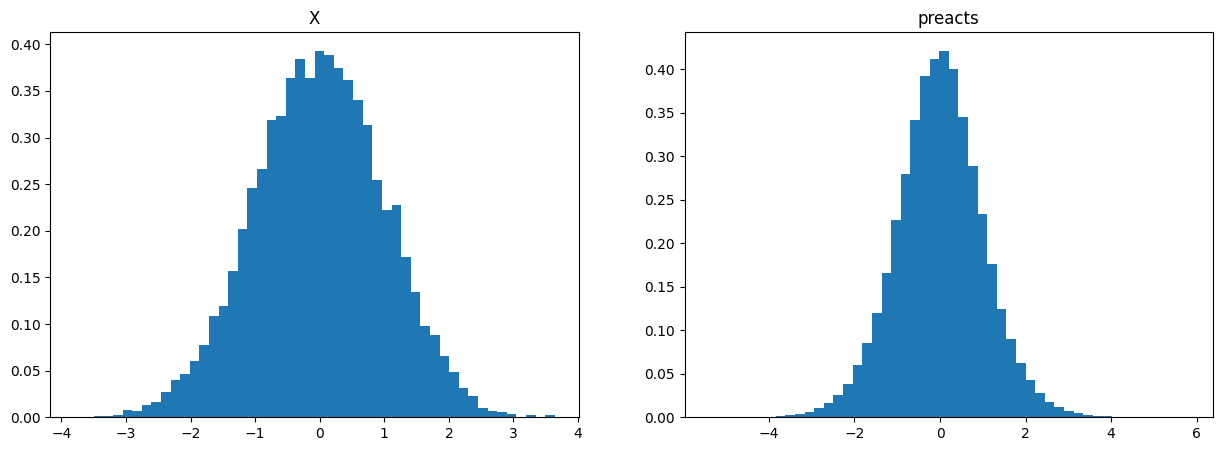

In [80]:
X = torch.randn(1000, embed_size)
w = torch.randn(embed_size, num_neurons) / (embed_size**0.5)

preacts = X @ w

print(f"{X.mean()=}, {X.std()=}")
print(f"{preacts.mean()=}, {preacts.std()=}")

fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), bins=50, density=True)
plt.title("X")

plt.subplot(122)
plt.hist(preacts.view(-1).tolist(), bins=50, density=True)
plt.title("preacts")
pass

In [81]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)

# Multiply W1 by the Kaiming-normal to reduce the magnitude of the hidden layer pre-activations
W1 = (
    torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g)
    * (5 / 3)
    * (1 / (embed_size * CONTEXT_LENGTH) ** 0.5)
)

# Multiply b1 by a small number to reduce the magnitude of the hidden layer pre-activations
b1 = torch.randn(size=(num_neurons,), generator=g) * 0.01

# Multiply W2 by a small number to reduce the magnitude of the output logits
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g) * 0.01

# Multiply b2 by 0 to remove the bias from the output logits initially
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [83]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1  # hidden layer, pre-activation
    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.3396
10000/100000 | Loss: 2.4347
20000/100000 | Loss: 2.1309
30000/100000 | Loss: 2.0803
40000/100000 | Loss: 2.0711
50000/100000 | Loss: 2.3830
60000/100000 | Loss: 2.3448
70000/100000 | Loss: 2.1083
80000/100000 | Loss: 2.1334
90000/100000 | Loss: 2.0662


In [84]:
# Caculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0615
validation loss: 2.1140


# Batch Normalization

The idea behind [batch normalization](https://browse.arxiv.org/pdf/1502.03167.pdf) is to standardize the pre-activation layers to be roughly Gaussian (at initialization, at least) so that the activation function does not get saturated or remains unused. 

This means standardizing the pre-activation matrix to have a mean of 0 and a standard deviation of 1, and further scaling it by a factor $\gamma$ and shifting it by a factor $\beta$.

$$
\begin{align}
\hat{x} &= \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \\
y &= \gamma \hat{x} + \beta
\end{align}
$$

where $\epsilon$ is a small number to prevent division by 0.

In [9]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)

# Multiply W1 by the Kaiming-normal to reduce the magnitude of the hidden layer pre-activations
W1 = (
    torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g)
    * (5 / 3)
    * (1 / (embed_size * CONTEXT_LENGTH) ** 0.5)
)

# Multiply b1 by a small number to reduce the magnitude of the hidden layer pre-activations
b1 = torch.randn(size=(num_neurons,), generator=g) * 0.01

# Multiply W2 by a small number to reduce the magnitude of the output logits
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g) * 0.01

# Multiply b2 by 0 to remove the bias from the output logits initially
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

# Adding the gain and bias terms as parameters
bngain = torch.ones(size=(1, num_neurons))
bnbias = torch.zeros(size=(1, num_neurons))

params = [C, W1, b1, W2, b2, bngain, bnbias]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 12297


In [10]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1  # hidden layer, pre-activation

    # Applying the batch normalization
    # Standardizing the activations, then scaling and shifting them

    hpreact = (
        bngain
        * (
            (hpreact - hpreact.mean(dim=0, keepdims=True))
            / hpreact.std(dim=0, keepdims=True)
        )
        + bnbias
    )
    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.3270
10000/100000 | Loss: 2.4685
20000/100000 | Loss: 2.1825
30000/100000 | Loss: 2.4832
40000/100000 | Loss: 2.3130
50000/100000 | Loss: 1.9100
60000/100000 | Loss: 2.1014
70000/100000 | Loss: 2.0403
80000/100000 | Loss: 1.8517
90000/100000 | Loss: 2.3318


### Second order effect

The batch normalization layer introduces a second order effect. Since the $\gamma$ and $\beta$ parameters are learned for an entire batch, the pre-activation layer is jittered around the true value. In other words, the normalization adds a sort of entropy in the model, acting as a regularizer, even though the dependence of one example on the other examples is not desriable (which leads to other forms of normalization such as layer normalization and instance normalization).

To correctly calculate the performance of the model, we calibrate the model after training. This means computing the batch normalization mean and standard deviation over the training set, given all the other parameters.

In [14]:
# Calibrate the batch normalization parameters
with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

print(f"{bnmean.shape=}, {bnstd.shape=}")

bnmean.shape=torch.Size([1, 200]), bnstd.shape=torch.Size([1, 200])


In [15]:
# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = bngain * ((hpreact - bnmean) / bnstd) + bnbias
    h = torch.tanh(hpreact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0947
validation loss: 2.1231


#### Running batch normalization

Alternatively, we could compute the running mean and standard deviation while training the model. This is called **running batch normalization**.

Here, you simply keep track of the mean and standard deviation as:
$$
\begin{align*}
\mu_{\text{running}} &= \alpha \mu_{\text{running}} + (1-\alpha) \mu_{\text{batch}} \\
\sigma_{\text{running}} &= \alpha \sigma_{\text{running}} + (1-\alpha) \sigma_{\text{batch}}
\end{align*}
$$

where $\alpha$ (or $1-\alpha$) is a hyperparameter that controls the rate of decay (or momentum) of the running mean and standard deviation. Typically, $\alpha$ is set to 0.999.

Additionally, the bias parameter before the batch normalization layer is removed since the batch normalization layer already has a bias parameter.

In [21]:
embed_size = 10
num_neurons = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, embed_size), generator=g)

# Multiply W1 by the Kaiming-normal to reduce the magnitude of the hidden layer pre-activations
W1 = (
    torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g)
    * (5 / 3)
    * (1 / (embed_size * CONTEXT_LENGTH) ** 0.5)
)

# Remove b1 since we are using batch normalization
# b1 = torch.randn(size=(num_neurons,), generator=g) * 0.01

# Multiply W2 by a small number to reduce the magnitude of the output logits
W2 = torch.randn(size=(num_neurons, vocab_size), generator=g) * 0.01

# Multiply b2 by 0 to remove the bias from the output logits initially
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

# Adding the gain and bias terms as parameters
bngain = torch.ones(size=(1, num_neurons))
bnbias = torch.zeros(size=(1, num_neurons))

# Add the running mean and standard deviation parameters
bnmean_running = torch.zeros(size=(1, num_neurons))
bnstd_running = torch.ones(size=(1, num_neurons))

params = [C, W1, W2, b2, bngain, bnbias]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 12097


In [22]:
epochs = 100000
batch_size = 32
momentum = 0.999
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1  # hidden layer, pre-activation

    # Applying the batch normalization
    # Standardizing the activations, then scaling and shifting them

    bnmean_i = hpreact.mean(dim=0, keepdims=True)
    bnstd_i = hpreact.std(dim=0, keepdims=True)

    hpreact = bngain * ((hpreact - bnmean_i) / bnstd_i) + bnbias

    h = torch.tanh(hpreact)  # hidden layer with `tanh` nonlinearity
    logits = (h @ W2) + b2  # output layer

    # Calculate the running mean and standard deviation
    with torch.no_grad():
        bnmean_running = momentum * bnmean_running + (1 - momentum) * bnmean_i
        bnstd_running = momentum * bnstd_running + (1 - momentum) * bnstd_i

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in params:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.2968
10000/100000 | Loss: 1.9545
20000/100000 | Loss: 2.3227
30000/100000 | Loss: 2.5465
40000/100000 | Loss: 2.2389
50000/100000 | Loss: 1.9979
60000/100000 | Loss: 1.9713
70000/100000 | Loss: 2.2455
80000/100000 | Loss: 1.9484
90000/100000 | Loss: 2.4278


In [23]:
# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0937
validation loss: 2.1252


# Simulating PyTorch

In [6]:
g = torch.Generator().manual_seed(2147483647)


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out), generator=g) * (
            1 / fan_in**0.5
        )
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdims=True)
            xvar = x.var(dim=0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Standardize the input layer
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Scale and shift the output layer
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean

                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [144]:
n_embed = 10
n_hidden = 100

C = torch.randn(size=(vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed * CONTEXT_LENGTH, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1  # scale the output layer weights
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (
                5 / 3
            )  # scale the linear layer weights by the Kaiming-normal `tanh` constant

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of parameters: 46497


In [145]:
epochs = 100000
batch_size = 32
losses = []
updates = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())
    with torch.no_grad():
        # Append the update-data ratio for each parameter
        updates.append(
            [
                ((learning_rate * p.grad).std() / p.data.std()).log10().item()
                for p in parameters
            ]
        )

    if epoch > 1000:
        break

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

## Inspecting the neural network

Layer 1 (Tanh): mean=-0.00, std=0.75, saturated=19.03%
Layer 3 (Tanh): mean=-0.05, std=0.72, saturated=13.50%
Layer 5 (Tanh): mean=-0.04, std=0.73, saturated=11.81%
Layer 7 (Tanh): mean=0.01, std=0.73, saturated=11.72%
Layer 9 (Tanh): mean=-0.03, std=0.71, saturated=10.94%


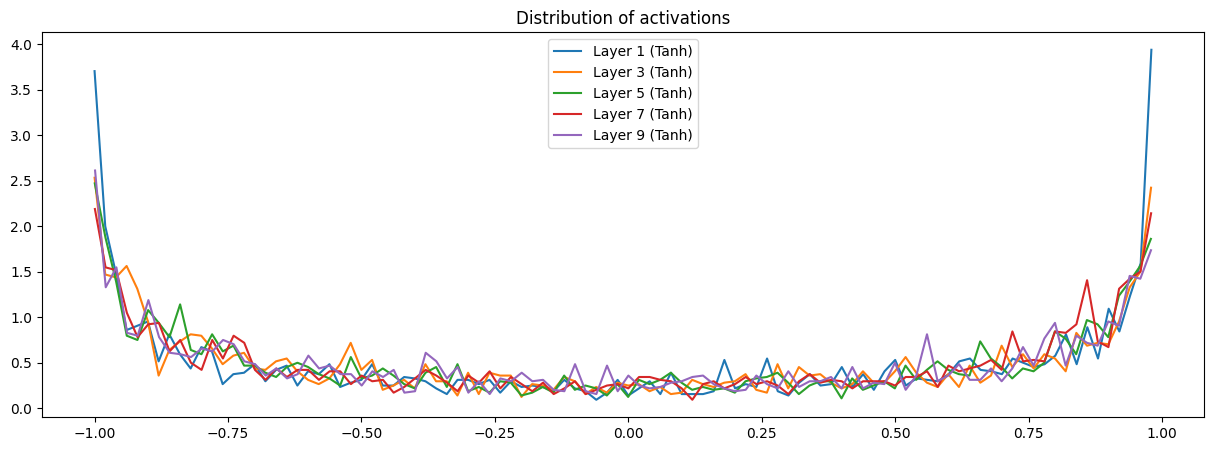

In [75]:
# Visualize the tanh layers
fig = plt.figure(figsize=(15, 5))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean={t.mean():.2f}, std={t.std():.2f}, saturated={(t.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Distribution of activations")
plt.show()

Layer 1 (Tanh): mean=0.00, std=0.00, saturated=0.00%
Layer 3 (Tanh): mean=-0.00, std=0.00, saturated=0.00%
Layer 5 (Tanh): mean=-0.00, std=0.00, saturated=0.00%
Layer 7 (Tanh): mean=0.00, std=0.00, saturated=0.00%
Layer 9 (Tanh): mean=-0.00, std=0.00, saturated=0.00%


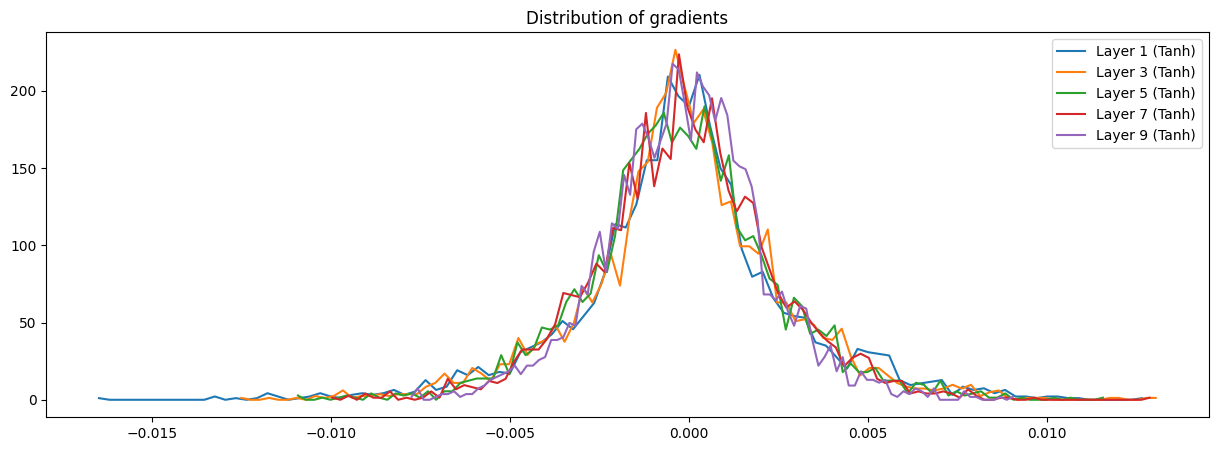

In [76]:
# Visualize the tanh gradient layers
fig = plt.figure(figsize=(15, 5))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean={t.mean():.2f}, std={t.std():.2f}, saturated={(t.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Distribution of gradients")
plt.show()

Parameter 0 ((27, 10)): mean=0.00, std=0.01, grad:data ratio=0.01
Parameter 1 ((30, 100)): mean=-0.00, std=0.01, grad:data ratio=0.03
Parameter 3 ((100, 100)): mean=0.00, std=0.01, grad:data ratio=0.04
Parameter 5 ((100, 100)): mean=0.00, std=0.01, grad:data ratio=0.04
Parameter 7 ((100, 100)): mean=-0.00, std=0.01, grad:data ratio=0.03
Parameter 9 ((100, 100)): mean=0.00, std=0.00, grad:data ratio=0.03
Parameter 11 ((100, 27)): mean=0.00, std=0.02, grad:data ratio=0.33


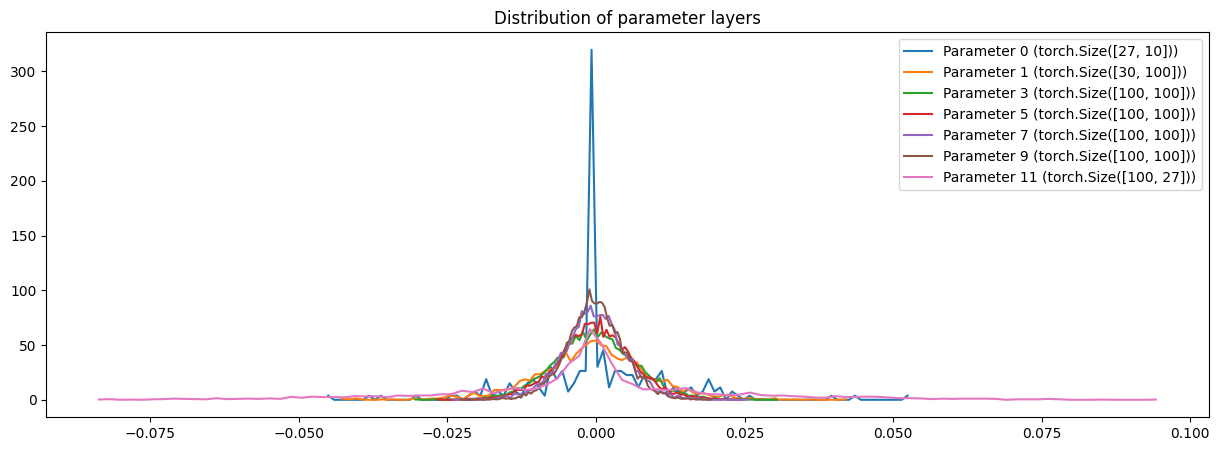

In [77]:
# Visualize the parameters
fig = plt.figure(figsize=(15, 5))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"Parameter {i} ({tuple(p.shape)}): mean={t.mean():.2f}, std={t.std():.2f}, grad:data ratio={t.std() / p.std():.2f}"
        )

        hy, hx = torch.histogram(t, density=True)

        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Parameter {i} ({p.shape})")

plt.legend(legends)
plt.title("Distribution of parameter layers")
plt.show()

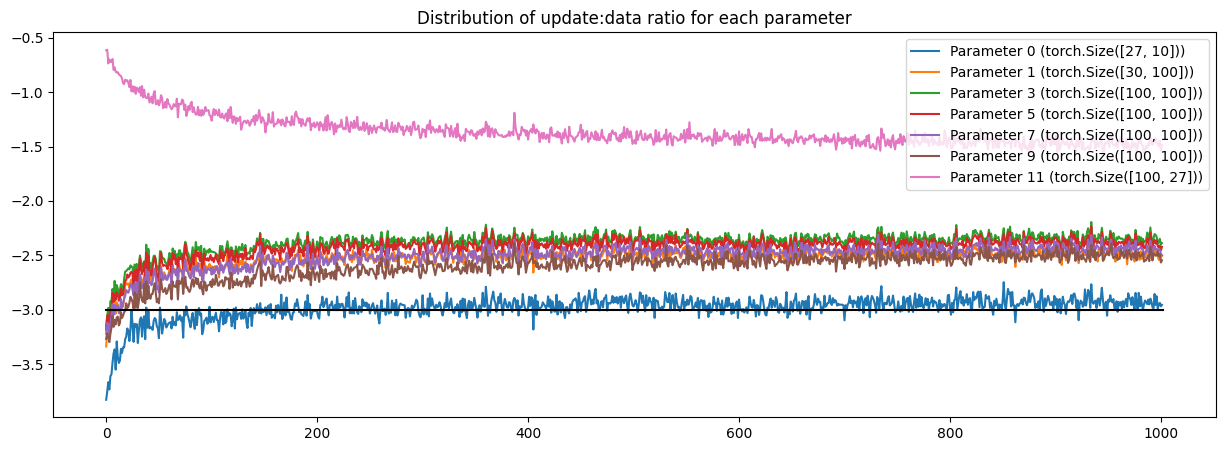

In [80]:
# Visualize the parameters
fig = plt.figure(figsize=(15, 5))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])
        legends.append(f"Parameter {i} ({p.shape})")


# Guideline, roughly ~1e-3
plt.plot([0, len(updates)], [-3, -3], "k")

plt.legend(legends)
plt.title("Distribution of update:data ratio for each parameter")
plt.show()

In [62]:
# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]

    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 3.2699
validation loss: 3.2697


## Batch normalization

In [7]:
n_embed = 10
n_hidden = 100

C = torch.randn(size=(vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed * CONTEXT_LENGTH, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1  # scale the gamma parameter of the output layer
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (
                1.0
            )  # scale the linear layer weights by the Kaiming-normal `tanh` constant

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 47024


In [8]:
epochs = 50000
batch_size = 32
losses = []
updates = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())
    with torch.no_grad():
        # Append the update-data ratio for each parameter
        updates.append(
            [
                ((learning_rate * p.grad).std() / p.data.std()).log10().item()
                for p in parameters
            ]
        )

0/50000 | Loss: 3.2959
10000/50000 | Loss: 2.0283
20000/50000 | Loss: 2.2172
30000/50000 | Loss: 2.4196
40000/50000 | Loss: 2.1616


Layer 2 (Tanh): mean=-0.01, std=0.69, saturated=11.56%
Layer 5 (Tanh): mean=-0.02, std=0.72, saturated=12.59%
Layer 8 (Tanh): mean=-0.01, std=0.72, saturated=11.00%
Layer 11 (Tanh): mean=-0.01, std=0.73, saturated=11.19%
Layer 14 (Tanh): mean=0.01, std=0.74, saturated=11.03%


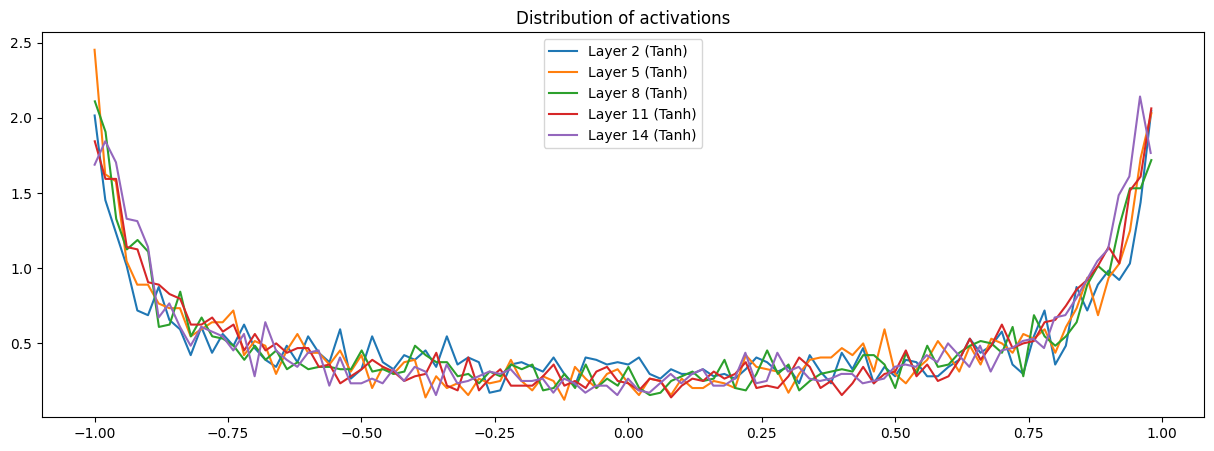

In [9]:
# Visualize the tanh layers
fig = plt.figure(figsize=(15, 5))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean={t.mean():.2f}, std={t.std():.2f}, saturated={(t.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Distribution of activations")
plt.show()

Layer 2 (Tanh): mean=0.00, std=0.00, saturated=0.00%
Layer 5 (Tanh): mean=-0.00, std=0.00, saturated=0.00%
Layer 8 (Tanh): mean=0.00, std=0.00, saturated=0.00%
Layer 11 (Tanh): mean=0.00, std=0.00, saturated=0.00%
Layer 14 (Tanh): mean=-0.00, std=0.00, saturated=0.00%


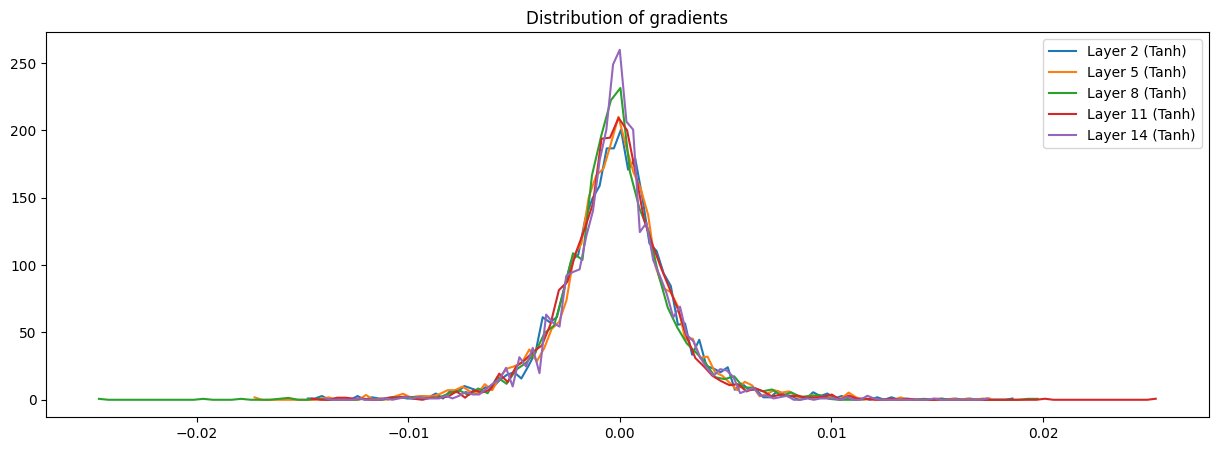

In [10]:
# Visualize the tanh gradient layers
fig = plt.figure(figsize=(15, 5))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean={t.mean():.2f}, std={t.std():.2f}, saturated={(t.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Distribution of gradients")
plt.show()

Parameter 0 ((27, 10)): mean=0.00, std=0.01, grad:data ratio=0.01
Parameter 1 ((30, 100)): mean=-0.00, std=0.01, grad:data ratio=0.03
Parameter 4 ((100, 100)): mean=0.00, std=0.01, grad:data ratio=0.03
Parameter 7 ((100, 100)): mean=-0.00, std=0.01, grad:data ratio=0.04
Parameter 10 ((100, 100)): mean=0.00, std=0.01, grad:data ratio=0.03
Parameter 13 ((100, 100)): mean=-0.00, std=0.00, grad:data ratio=0.03
Parameter 16 ((100, 27)): mean=-0.00, std=0.01, grad:data ratio=0.03


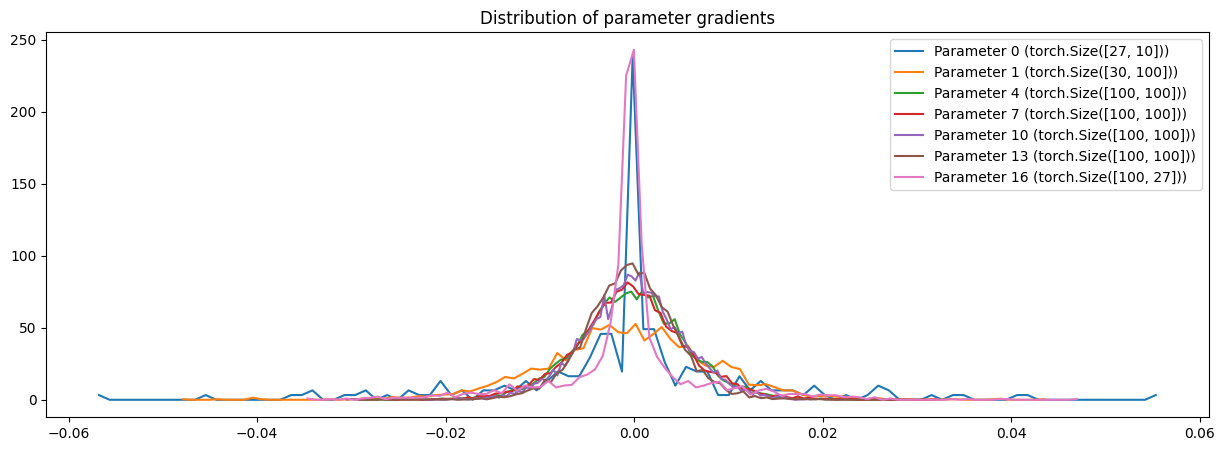

In [11]:
# Visualize the parameters
fig = plt.figure(figsize=(15, 5))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"Parameter {i} ({tuple(p.shape)}): mean={t.mean():.2f}, std={t.std():.2f}, grad:data ratio={t.std() / p.std():.2f}"
        )

        hy, hx = torch.histogram(t, density=True)

        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Parameter {i} ({p.shape})")

plt.legend(legends)
plt.title("Distribution of parameter gradients")
plt.show()

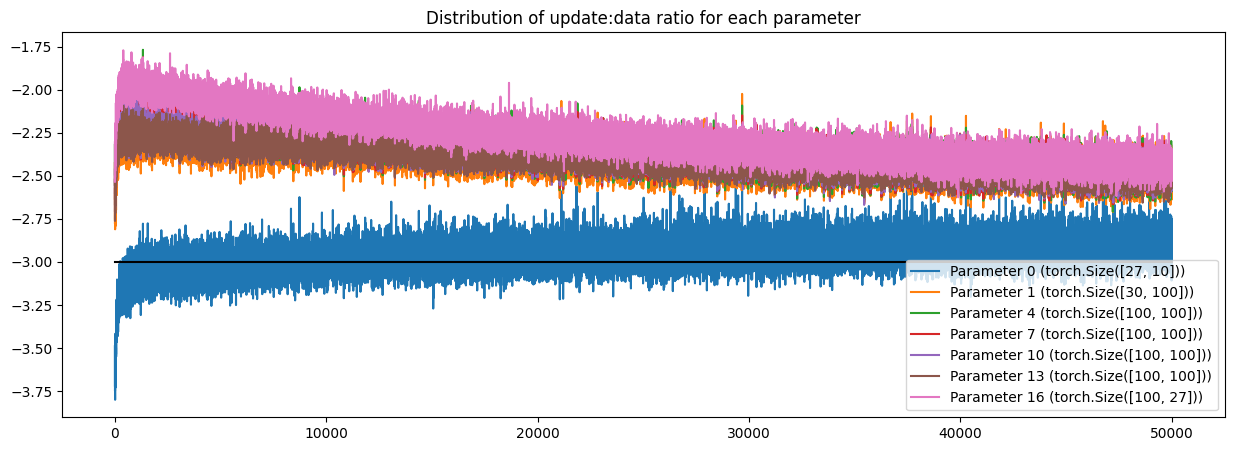

In [12]:
# Visualize the parameters
fig = plt.figure(figsize=(15, 5))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])
        legends.append(f"Parameter {i} ({p.shape})")


# Guideline, roughly ~1e-3
plt.plot([0, len(updates)], [-3, -3], "k")

plt.legend(legends)
plt.title("Distribution of update:data ratio for each parameter")
plt.show()

In [13]:
# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]

    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0958
validation loss: 2.1350
